# Examining Home Configurations and Their Effect on Sale Prices
### by Steven Tran

## 02: Preprocessing, Feature Engineering, and Modeling

|Project Notebooks|
|--------|
|[00_Problem_Statement_and_Project_Overview](00_Problem_Statement_and_Project_Overview.ipynb)|
|[01_EDA_and_Cleaning](01_EDA_and_Cleaning.ipynb)|
|[02_Preprocessing_FeatureEngineering_Modeling](02_Preprocessing_FeatureEngineering_Modeling.ipynb)|
|[03_Kaggle_Submissions](04_Kaggle_Submissions.ipynb)|


In [1]:
# Import required modules:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn import metrics

### Preprocessing

In this section, I'll be doing a small amount of manual feature engineering prompted the problem statement, and I'll also be using `PolyNomialFeatures` to fit a model with entirely too many features to later use as a model benchmark.

In [2]:
floorplans = pd.read_csv('../datasets/cleaned/ames_train_clean.csv')

In [3]:
# add up all the bathrooms to get a full count:
floorplans['baths'] = floorplans[['bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath']].agg(sum, 1).astype(int)

In [4]:
# drop all the constituent columns we used to make our new column:
floorplans.drop(columns=['bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath'],inplace=True)

In [5]:
# review how distributed our full count of bathrooms is
floorplans['baths'].value_counts()

2    815
3    656
1    314
4    241
5     13
6      4
8      2
Name: baths, dtype: int64

In [6]:
# since there are few homes with 5 or more bathrooms, bin those homes together into a 5+ category
floorplans.loc[:,'baths'] = [str(x) if x <=4 else '5+' for x in floorplans['baths']]

In [7]:
# do the same thing for bedrooms
floorplans.loc[:,'beds'] = [1 if x == 0 else x if x < 5 else '5+' for x in floorplans['bedroom_abvgr']]

In [8]:
predictors = ['beds','baths','house_style'] # will be taking interaction terms

Though we cleaned the data extensively in [01_EDA_and_Cleaning](01_EDA_and_Cleaning.ipynb), we won't be using all the columns for the analysis required for the project problem statement. Fortunately, we got to use those other columns in the Kaggle submission, so that work was not wasted.

We can drop all the rows that are not used in our definition of **home configuration**.

In [9]:
# lose all the other columns we won't be using for our models
floorplans = floorplans[(predictors + ['saleprice'])] 

In [10]:
#need to turn bedroom and bath into categorical; need to bin gr_liv_area
floorplans.loc[:,'beds'] = floorplans['beds'].astype(str)
floorplans.loc[:,'baths'] = floorplans['baths'].astype(str)

In [11]:
# review the distribution of our house styles. will group the less represented categories into
# a broad category
floorplans['house_style'].value_counts()

1Story    1056
2Story     596
1.5Fin     218
SLvl        93
SFoyer      50
2.5Unf      14
1.5Unf      12
2.5Fin       6
Name: house_style, dtype: int64

In [12]:
# if it's not a 1- or 2- story, call it 'unique'
floorplans.loc[:,'house_style'] = [x if x in ['1Story','2Story'] else 'Unique(2.5, 1.5, other)' for x in floorplans['house_style']]

In [13]:
floorplans['house_style'].value_counts()

1Story                     1056
2Story                      596
Unique(2.5, 1.5, other)     393
Name: house_style, dtype: int64

In [14]:
floorplans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2045 entries, 0 to 2044
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   beds         2045 non-null   object
 1   baths        2045 non-null   object
 2   house_style  2045 non-null   object
 3   saleprice    2045 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 64.0+ KB


In [15]:
#set aside a df for some presentation plotting pre-dummification:
undummied = floorplans
undummied.drop(undummied[undummied['saleprice']<60000].index,inplace=True)

In [16]:
# dummify all of our configuration constructor variables
floorplans = pd.get_dummies(floorplans, columns=list(floorplans.columns)[:-1])

In [17]:
list(floorplans.columns)

['saleprice',
 'beds_1',
 'beds_2',
 'beds_3',
 'beds_4',
 'beds_5+',
 'baths_1',
 'baths_2',
 'baths_3',
 'baths_4',
 'baths_5+',
 'house_style_1Story',
 'house_style_2Story',
 'house_style_Unique(2.5, 1.5, other)']

For this analysis, I used `pd.get_dummies()` with `drop_first` NOT set to `True`. This is so that I could selectively choose for each of the three dummified variables which one would be our reference category.

For this analysis, I chose the **1-story 3-bed, 2-bath** as the reference category.|

In [18]:
#call on these again when we need to interpret what the coefficients mean
reference_cols = ['beds_3','baths_2', 'house_style_1Story']
# THIS IS THE BASELINE CONFIGURATION

---

Before we drop the reference columns, we need to make a good number of interaction terms, bed x bath x house_style. The coefficients on the interactions will be configurations in relation to the basline configuration.

In [19]:
#1story homes:
floorplans['1s1b1b'] = floorplans['beds_1']*floorplans['baths_1']*floorplans['house_style_1Story']
floorplans['1s2b1b'] = floorplans['beds_2']*floorplans['baths_1']*floorplans['house_style_1Story']
floorplans['1s3b1b'] = floorplans['beds_3']*floorplans['baths_1']*floorplans['house_style_1Story']
floorplans['1s4b1b'] = floorplans['beds_4']*floorplans['baths_1']*floorplans['house_style_1Story']
floorplans['1s5b1b'] = floorplans['beds_5+']*floorplans['baths_1']*floorplans['house_style_1Story']
floorplans['1s2b2b'] = floorplans['beds_2']*floorplans['baths_2']*floorplans['house_style_1Story']
floorplans['1s3b2b'] = floorplans['beds_3']*floorplans['baths_2']*floorplans['house_style_1Story']
floorplans['1s4b2b'] = floorplans['beds_4']*floorplans['baths_2']*floorplans['house_style_1Story']
floorplans['1s5b2b'] = floorplans['beds_5+']*floorplans['baths_2']*floorplans['house_style_1Story']
floorplans['1s3b3b'] = floorplans['beds_3']*floorplans['baths_3']*floorplans['house_style_1Story']
floorplans['1s4b3b'] = floorplans['beds_4']*floorplans['baths_3']*floorplans['house_style_1Story']
floorplans['1s5b3b'] = floorplans['beds_5+']*floorplans['baths_3']*floorplans['house_style_1Story']
floorplans['1s4b4b'] = floorplans['beds_4']*floorplans['baths_4']*floorplans['house_style_1Story']
floorplans['1s5b4b'] = floorplans['beds_5+']*floorplans['baths_4']*floorplans['house_style_1Story']
floorplans['1s5b5b'] = floorplans['beds_5+']*floorplans['baths_5+']*floorplans['house_style_1Story']

#2story homes:
floorplans['2s2b2b'] = floorplans['beds_2']*floorplans['baths_2']*floorplans['house_style_2Story']
floorplans['2s3b2b'] = floorplans['beds_3']*floorplans['baths_2']*floorplans['house_style_2Story']
floorplans['2s4b2b'] = floorplans['beds_4']*floorplans['baths_2']*floorplans['house_style_2Story']
floorplans['2s5b2b'] = floorplans['beds_5+']*floorplans['baths_2']*floorplans['house_style_2Story']
floorplans['2s3b3b'] = floorplans['beds_3']*floorplans['baths_3']*floorplans['house_style_2Story']
floorplans['2s4b3b'] = floorplans['beds_4']*floorplans['baths_3']*floorplans['house_style_2Story']
floorplans['2s5b3b'] = floorplans['beds_5+']*floorplans['baths_3']*floorplans['house_style_2Story']
floorplans['2s4b4b'] = floorplans['beds_4']*floorplans['baths_4']*floorplans['house_style_2Story']
floorplans['2s5b4b'] = floorplans['beds_5+']*floorplans['baths_4']*floorplans['house_style_2Story']
floorplans['2s5b5b'] = floorplans['beds_5+']*floorplans['baths_5+']*floorplans['house_style_2Story']

#UniqueStyles:
floorplans['u1b1b'] = floorplans['beds_1']*floorplans['baths_1']*floorplans['house_style_Unique(2.5, 1.5, other)']
floorplans['u2b1b'] = floorplans['beds_2']*floorplans['baths_1']*floorplans['house_style_Unique(2.5, 1.5, other)']
floorplans['u2b2b'] = floorplans['beds_2']*floorplans['baths_2']*floorplans['house_style_Unique(2.5, 1.5, other)']
floorplans['u3b2b'] = floorplans['beds_3']*floorplans['baths_2']*floorplans['house_style_Unique(2.5, 1.5, other)']
floorplans['u4b2b'] = floorplans['beds_4']*floorplans['baths_2']*floorplans['house_style_Unique(2.5, 1.5, other)']
floorplans['u3b3b'] = floorplans['beds_3']*floorplans['baths_3']*floorplans['house_style_Unique(2.5, 1.5, other)']
floorplans['u4b3b'] = floorplans['beds_4']*floorplans['baths_3']*floorplans['house_style_Unique(2.5, 1.5, other)']
floorplans['u5b3b'] = floorplans['beds_5+']*floorplans['baths_3']*floorplans['house_style_Unique(2.5, 1.5, other)']
floorplans['u4b4b'] = floorplans['beds_4']*floorplans['baths_4']*floorplans['house_style_Unique(2.5, 1.5, other)']
floorplans['u5b4b'] = floorplans['beds_5+']*floorplans['baths_4']*floorplans['house_style_Unique(2.5, 1.5, other)']
floorplans['u5b5b'] = floorplans['beds_5+']*floorplans['baths_5+']*floorplans['house_style_Unique(2.5, 1.5, other)']

In [20]:
floorplans.drop(columns=reference_cols, inplace=True)

In [21]:
### Remove homes with price less than 60000 -- those are outliers for this analysis,
### but were kept in for the kaggle competition
floorplans.drop(floorplans[floorplans['saleprice']<60000].index,inplace=True)

### Modeling

For this section, I'll be deploying the dummified data into four models:
* Standard Multiple Linear Regression
* Standard Multiple Linear Regression (with PolyNomialFeatures)
* Ridge-regularized Linear Regression and
* Lasso-regularized Linear Regression

First, we need to establish a Baseline to benchmark our model performance against:



In [22]:
#define variables X and y:
X = floorplans.drop(columns=['saleprice'])
y = floorplans['saleprice']
y
#set up train-test split:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
y_baseline = np.mean(y_test)
y_baseline = [y_baseline for value in y_test]

In [23]:
#get standard deviations to UNDO standardization for interpretations at the end:
X_train_stdevs = [X_train[x].std() for x in list(X_train.columns)]
X_test_stdevs = [X_test[x].std() for x in list(X_test.columns)]
np.mean(X_train_stdevs), np.mean(X_test_stdevs)

(0.15558815276652402, 0.15495600001446339)

In [24]:
#baseline score, using means of the testing data:
baseline_r2_rmse = (metrics.r2_score(y_test, y_baseline),
                    metrics.mean_squared_error(y_test, y_baseline,squared=False))

In [25]:
baseline_r2_rmse

(0.0, 80570.91666056587)

With an R2 of 0, a predictive model constructed from using just the observed target means in the training dataset is considered a very bad model! Great! Nowhere to go but up.

In [26]:
scores = [('baseline',baseline_r2_rmse)]

---

Standard MLS

In [27]:
# Instantiate:
lr = LinearRegression()

In [28]:
# Fit:
lr.fit(X_train,y_train)
# Predict:
y_pred = lr.predict(X_test)
# Evaluate:
smlr_r2_rmse = (metrics.r2_score(y_test,y_pred),
                metrics.mean_squared_error(y_test, y_pred,squared=False))

In [29]:
smlr_r2_rmse

(0.365976439796049, 64155.072915840654)

In [30]:
#Add the scores. We'll review after all the models have run
scores.append(('smlr', smlr_r2_rmse))

---

Standard MLS but with POLYNOMIAL FEATURES

In [31]:
poly = PolynomialFeatures(degree=3,include_bias=False)

In [32]:
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [33]:
poly.get_feature_names(input_features = X.columns)

['beds_1',
 'beds_2',
 'beds_4',
 'beds_5+',
 'baths_1',
 'baths_3',
 'baths_4',
 'baths_5+',
 'house_style_2Story',
 'house_style_Unique(2.5, 1.5, other)',
 '1s1b1b',
 '1s2b1b',
 '1s3b1b',
 '1s4b1b',
 '1s5b1b',
 '1s2b2b',
 '1s3b2b',
 '1s4b2b',
 '1s5b2b',
 '1s3b3b',
 '1s4b3b',
 '1s5b3b',
 '1s4b4b',
 '1s5b4b',
 '1s5b5b',
 '2s2b2b',
 '2s3b2b',
 '2s4b2b',
 '2s5b2b',
 '2s3b3b',
 '2s4b3b',
 '2s5b3b',
 '2s4b4b',
 '2s5b4b',
 '2s5b5b',
 'u1b1b',
 'u2b1b',
 'u2b2b',
 'u3b2b',
 'u4b2b',
 'u3b3b',
 'u4b3b',
 'u5b3b',
 'u4b4b',
 'u5b4b',
 'u5b5b',
 'beds_1^2',
 'beds_1 beds_2',
 'beds_1 beds_4',
 'beds_1 beds_5+',
 'beds_1 baths_1',
 'beds_1 baths_3',
 'beds_1 baths_4',
 'beds_1 baths_5+',
 'beds_1 house_style_2Story',
 'beds_1 house_style_Unique(2.5, 1.5, other)',
 'beds_1 1s1b1b',
 'beds_1 1s2b1b',
 'beds_1 1s3b1b',
 'beds_1 1s4b1b',
 'beds_1 1s5b1b',
 'beds_1 1s2b2b',
 'beds_1 1s3b2b',
 'beds_1 1s4b2b',
 'beds_1 1s5b2b',
 'beds_1 1s3b3b',
 'beds_1 1s4b3b',
 'beds_1 1s5b3b',
 'beds_1 1s4b4b',
 '

In [34]:
poly_lr = LinearRegression()

In [35]:
# Fit
poly_lr.fit(X_train_poly,y_train)

LinearRegression()

In [36]:
# Predict
y_pred_poly = poly_lr.predict(X_test_poly)

In [37]:
# Evaluate
poly_r2_rmse = (metrics.r2_score(y_test,y_pred_poly),
                metrics.mean_squared_error(y_test,y_pred_poly,squared=False))

In [38]:
#Add the scores. We'll review after all the models have run
scores.append(('mls_poly', poly_r2_rmse))

---

Ridge regression, using GridSearchCV

In [39]:
# Instantiate:
r_ss = StandardScaler()

# Standardize:
r_Z_train = r_ss.fit_transform(X_train)
r_Z_test = r_ss.transform(X_test)

# Define Hyperparameter Set for Ridge:
ridge_params = {
    'alpha': np.logspace(-2,10,100)
}

# Instantiate the GridSearchCV:
ridge_gs = GridSearchCV(Ridge(),
                        ridge_params,
                        cv=5,
                        verbose=1)

# Fit:
ridge_gs.fit(r_Z_train, y_train)

# Predict:
y_pred_r = ridge_gs.predict(r_Z_test)

# Evalute:
ridge_r2_rmse = (metrics.r2_score(y_test,y_pred_r),
                 metrics.mean_squared_error(y_test,y_pred_r, squared=False))

scores.append(('ridge',ridge_r2_rmse))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


---

LASSO with GridSearchCV

In [40]:
# Instantiate:
l_ss = StandardScaler()

# Standardize:
l_Z_train = l_ss.fit_transform(X_train)
l_Z_test = l_ss.transform(X_test)

# Define Hyperparameter Set for Lasso:
lasso_params = {
    'alpha': np.logspace(-2,10,100),
    'max_iter': [5000]
}

# Instantiate the GridSearchCV:
lasso_gs = GridSearchCV(Lasso(),
                        lasso_params,
                        cv=5,
                        verbose=1)

# Fit:
lasso_gs.fit(l_Z_train, y_train)

# Predict:
y_pred_l = lasso_gs.predict(l_Z_test)

# Evalute:
lasso_r2_rmse = (metrics.r2_score(y_test,y_pred_l),
                 metrics.mean_squared_error(y_test,y_pred_l, squared=False))

scores.append(('lasso',lasso_r2_rmse))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


---

Review Results:

In [41]:
scores

[('baseline', (0.0, 80570.91666056587)),
 ('smlr', (0.365976439796049, 64155.072915840654)),
 ('mls_poly', (-8.440649192873233e+21, 7402292292854698.0)),
 ('ridge', (0.3694798509666912, 63977.577185240974)),
 ('lasso', (0.3722479353460759, 63836.986809696995))]

---

Based on the above, it seems like our best choice will be to use the **ridge-regularized multiple linear regression model for inference** on what house style configurations should be ideal.

On none of these models is the R2 predictive power anything to gloat about. Further, the R2 and root mean squared error for each of the standard multiple linear regression, ridge, and lasso are also so close to one another. That said, Since ridge has the lowest RMSE, we'll go with that model.

---

## Production Model

In [42]:
# Using the hyperparameters found in the lasso_gs, 
#run a lasso to get coefficients on our predictors.
ridge_reg = Ridge(alpha=ridge_gs.best_params_['alpha'])

# Fit:
ridge_reg.fit(r_Z_train, y_train)

# Predict:
y_pred_ridge = ridge_reg.predict(l_Z_test)

# Evaluate (check that they match our lasso_gs scores output above):
metrics.r2_score(y_test,y_pred_ridge), metrics.mean_squared_error(y_test,y_pred_ridge,squared=False)

(0.3694798509666912, 63977.577185240974)

In [43]:
ridge_reg.coef_*X_train_stdevs+np.mean(X_train)


beds_1                                     4.461946
beds_2                                 -1261.346785
beds_4                                  1024.915269
beds_5+                                  845.832714
baths_1                                 2003.673506
baths_3                                13325.281645
baths_4                                14160.197666
baths_5+                                 829.974624
house_style_2Story                    -17117.114392
house_style_Unique(2.5, 1.5, other)   -13917.733680
1s1b1b                                  -432.490151
1s2b1b                                 -5003.849229
1s3b1b                                 -3411.406439
1s4b1b                                   -89.873162
1s5b1b                                     0.000000
1s2b2b                                 -2257.793599
1s3b2b                                 -2648.307645
1s4b2b                                  -736.569024
1s5b2b                                  -163.570410
1s3b3b      

In [44]:
# use the standard deviation of the training data to undo the scaling transformation for interpretability:
# Extract coefficients into a DF:
ridge_coef = pd.DataFrame((ridge_reg.coef_*X_train_stdevs)+np.mean(X_train),index=X.columns,columns=['coef'])

#only grab the coefficients for the configurations:
configs = list(floorplans.columns)[11:]

results = ridge_coef.loc[configs,:].sort_values('coef', ascending = False)

results['config'] = [f'Unique(2.5, 1.5, other) {x[1:]}' if x[0] == 'u' else f'1-Story {x[2:]}' if x[0] == '1' else f'2-Story {x[2:]}'  for x in results.index]

results.columns = results.columns[::-1]

results[['coef','config']] = results[['config', 'coef']]

results.loc[:,'coef'] = round(results['coef'],2)

In [45]:
results[results['coef'] != 0]

,config,coef
2s4b3b,2-Story 4b3b,1983.11
u3b2b,"Unique(2.5, 1.5, other) 3b2b",1937.26
2s3b3b,2-Story 3b3b,1468.74
2s4b4b,2-Story 4b4b,1281.86
u2b2b,"Unique(2.5, 1.5, other) 2b2b",603.97
u4b2b,"Unique(2.5, 1.5, other) 4b2b",589.04
2s4b2b,2-Story 4b2b,461.55
2s3b2b,2-Story 3b2b,449.67
u4b3b,"Unique(2.5, 1.5, other) 4b3b",241.63
2s2b2b,2-Story 2b2b,77.56


---

### Bonus Visualizations

These were charts that couldn't be created until after the interaction terms were defined. I used them in the project presentation slides.

In [46]:
count_configs = pd.DataFrame(zip(list(floorplans.columns)[11:],floorplans[list(floorplans.columns)[11:]].sum()), columns=['config', 'count'])

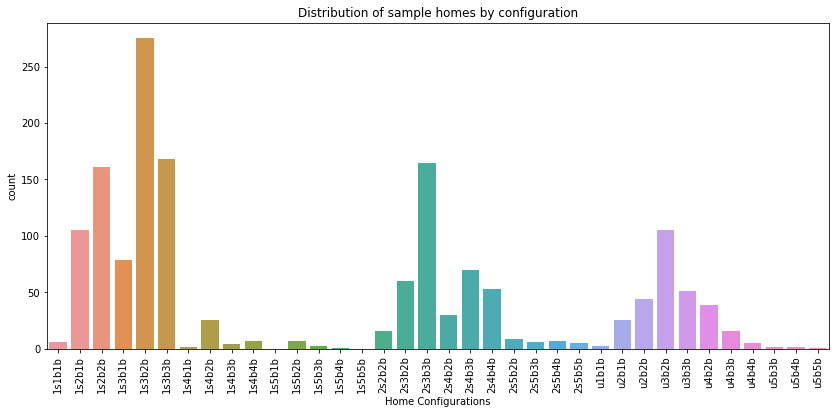

In [47]:
plt.figure(figsize=(14,6))
sns.barplot(x=count_configs['config'].sort_values(),y=count_configs['count'])
plt.xticks(x=count_configs['config'], rotation='vertical')
plt.title('Distribution of sample homes by configuration')
plt.xlabel('Home Configurations');

In [48]:
floorplans.shape

(2027, 47)

C:\Users\yumst\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 10.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


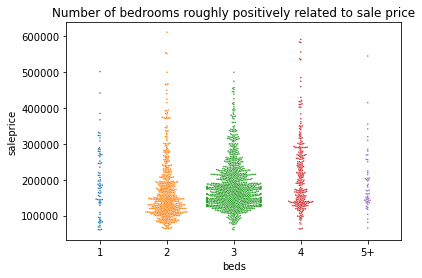

In [49]:

plt.figure(figsize=(6,4))
sns.swarmplot(x=undummied['beds'],y=undummied['saleprice'], order = ['1','2','3','4','5+'],size=1.5)
plt.title('Number of bedrooms roughly positively related to sale price');

C:\Users\yumst\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 12.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


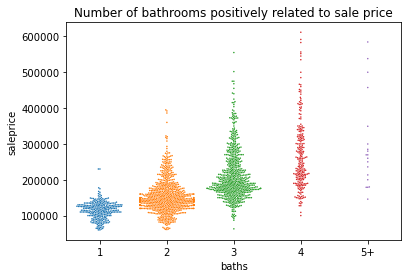

In [50]:
plt.figure(figsize=(6,4))
sns.swarmplot(x=undummied['baths'],y=undummied['saleprice'], order = ['1','2','3','4','5+'], size=1.5)
plt.title('Number of bathrooms positively related to sale price');

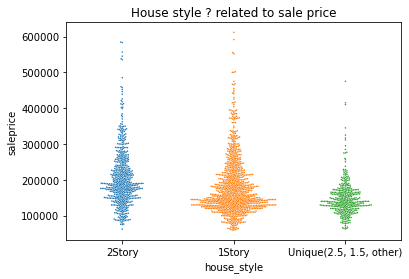

In [51]:
plt.figure(figsize=(6,4))
sns.swarmplot(x=undummied['house_style'],y=undummied['saleprice'], size=1.5)
plt.title('House style ? related to sale price');